## AC Transit GTFS - Bus Bunching (IN PROGRESS)

This notebook loads in route, stop, and trip information and locations collected from the AC Transit API, then uses geospatial analysis to identify bus bunching.

**Links**: 
- [AC Transit API Documentation](https://api.actransit.org/transit/Help)
- [Bus Bunching Explained Visually](https://setosa.io/bus/)

### Import Packages

In [2]:
import pandas as pd
import numpy as np
import csv
from datetime import datetime as dt

In [3]:
import folium
import matplotlib.pyplot as plt
import geopandas as gpd

from geopy.distance import great_circle

### Import Static GTFS - Stop Patterns, Trips

In [32]:
# import stops from .CSV file
stop_patterns_df = pd.read_csv("../data/ACTransit_StopPatterns.csv")

# convert dataframe to geodataframe
stop_patterns_gdf = gpd.GeoDataFrame(stop_patterns_df, 
                                     geometry=gpd.points_from_xy(stop_patterns_df.lon, stop_patterns_df.lat))

#display geodataframe
stop_patterns_gdf.head()

,RouteId,rtdir,lat,lon,stpid,stpnm,geometry
0,6,To Downtown Berkeley,37.802254,-122.274456,51636,10th St:Washington St,POINT (-122.27446 37.80225)
1,6,To Downtown Berkeley,37.802963,-122.274464,59444,11th St + Clay St,POINT (-122.27446 37.80296)
2,6,To Downtown Berkeley,37.804103,-122.269714,53602,Franklin St:14th St,POINT (-122.26971 37.80410)
3,6,To Downtown Berkeley,37.809587,-122.269413,57999,Thomas L Berkley Way + Telegraph Av,POINT (-122.26941 37.80959)
4,6,To Downtown Berkeley,37.814091,-122.268358,59991,Telegraph Av + 24th St,POINT (-122.26836 37.81409)


In [73]:
# import trips from .CSV file
trips_df = pd.read_csv("../data/ACTransit_Trips.csv")

# convert StartTime column to datetime format
trips_df.StartTime = pd.to_datetime(trips_df.StartTime, infer_datetime_format=True)

# display dataframe
trips_df.head()

,RouteId,Direction,TripId,StartTime
0,1,Northbound,7279073,2000-01-01 00:49:00
1,1,Northbound,7279074,2000-01-01 01:49:00
2,1,Northbound,7279075,2000-01-01 02:49:00
3,1,Northbound,7279076,2000-01-01 03:49:00
4,1,Northbound,7279077,2000-01-01 04:49:00


In [74]:
# change index to datetime
trips_df = trips_df.set_index('StartTime')

# group trips_df by 15 minute intervals ()
trips_count_df = trips_df.resample('15Min', base=0, label='right').count()
trips_count_df['time_short'] = trips_count_df.index.strftime("%H:%M")

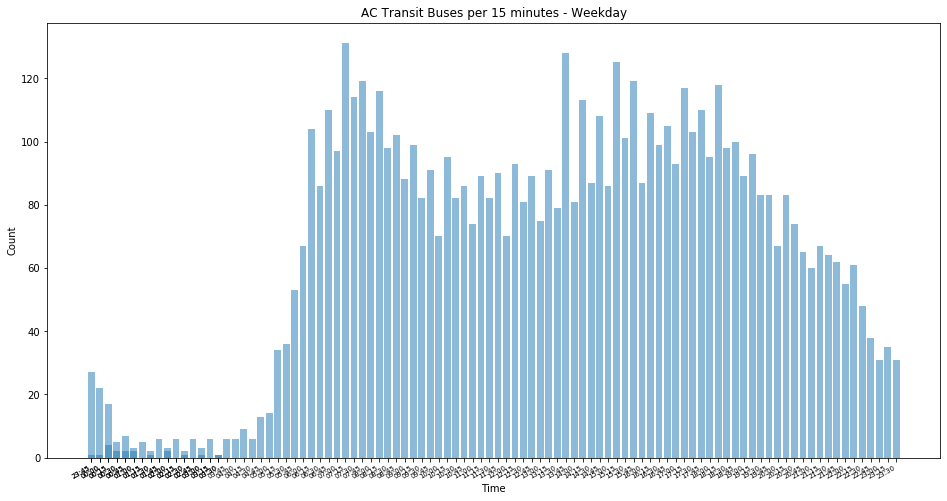

In [86]:
# plot count of trips through the day

# create plot
fig, ax = plt.subplots(figsize=(16, 8))

# create bar chart
ax.bar(trips_count_df['time_short'], trips_count_df['RouteId'], align='center', alpha=0.5)

# plot attributes
plt.xticks(trips_count_df['time_short'])
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('AC Transit Buses per 15 minutes - Weekday')

# fix crowded x-axis label
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='x-small')

# display
plt.show()

### Import Real-Time GTFS

In [87]:
# read in GTFS RT data
vehloc_df = pd.read_csv("../data/ACTransit_Veh_Loc_0303.csv")

# convert time column to a datetime
vehloc_df.time = pd.to_datetime(vehloc_df.time)

# convert trip_id to integer and drop extra values
vehloc_df.trip_id = vehloc_df.trip_id[0].astype(str)[:-4]
vehloc_df.trip_id = vehloc_df.trip_id.astype(int)

# convert dataframe to geodataframe
vehloc_gdf = gpd.GeoDataFrame(vehloc_df, geometry=gpd.points_from_xy(vehloc_df.longitude, vehloc_df.latitude))

# display geodataframe
vehloc_gdf.head()

,route_id,trip_id,vehicle_id,latitude,longitude,bearing,speed,unix_time,time,geometry
0,19,7422200,5020,37.767731,-122.233131,167.0,0.00000,1583269548,2020-03-03 13:05:48-08:00,POINT (-122.23313 37.76773)
1,34,7422200,5022,37.686657,-122.138054,88.0,10.72896,1583269549,2020-03-03 13:05:49-08:00,POINT (-122.13805 37.68666)
2,34,7422200,5023,37.718044,-122.178970,274.0,0.00000,1583269544,2020-03-03 13:05:44-08:00,POINT (-122.17897 37.71804)
3,212,7422200,5025,37.526546,-122.005966,304.0,0.00000,1583269546,2020-03-03 13:05:46-08:00,POINT (-122.00597 37.52655)
4,51A,7422200,1341,37.775002,-122.224571,305.0,0.00000,1583269541,2020-03-03 13:05:41-08:00,POINT (-122.22457 37.77500)


### Join Static and Real-Time data

testing on one bus route to start: `51B`

In [89]:
# create array of trip IDs on route 51B
trips_temp = trips_df[trips_df.RouteId =='51B'].TripId.unique()
trips_temp

array([7184370, 7184300, 7184328, 7184349, 7184398, 7184418, 7184439,
       7184372, 7184302, 7184330, 7184351, 7184400, 7184420, 7184460,
       7184374, 7184441, 7184304, 7184353, 7184332, 7184402, 7184483,
       7184462, 7184422, 7184376, 7184504, 7184443, 7184306, 7184355,
       7184334, 7184404, 7184485, 7184464, 7184424, 7184378, 7184506,
       7184445, 7184308, 7184357, 7184336, 7184406, 7184487, 7184466,
       7184426, 7184380, 7184508, 7184447, 7184310, 7184359, 7184338,
       7184408, 7184489, 7184468, 7184428, 7184382, 7184510, 7184449,
       7184312, 7184361, 7184340, 7184410, 7184491, 7184470, 7184430,
       7184384, 7184512, 7184451, 7184314, 7184363, 7184342, 7184412,
       7184493, 7184472, 7184432, 7184386, 7184514, 7184453, 7184316,
       7184365, 7184344, 7184414, 7184495, 7184474, 7184434, 7184388,
       7184516, 7184455, 7184318, 7184367, 7184497, 7184476, 7184390,
       7184457, 7184320, 7184499, 7184478, 7184392, 7184322, 7184501,
       7184480, 7184

In [90]:
# check where these trips are in the real-time gdf
vehloc_gdf[vehloc_gdf.trip_id.isin(trips_temp)]

,route_id,trip_id,vehicle_id,latitude,longitude,bearing,speed,unix_time,time,geometry


In [ ]:
# ^ odd that there are no matching trips....
# am I not properly reading in the trip ids?

## TESTING BELOW

In [130]:
# https://stackoverflow.com/questions/56520780/how-to-use-geopanda-or-shapely-to-find-nearest-point-in-same-geodataframe

# NOT WHAT I WANT

from shapely.geometry import Point
from shapely.ops import nearest_points

for index, row in vehloc_gdf.iterrows():
    point = row.geometry
    multipoint = stop_patterns_gdf.drop(index, axis=0).geometry.unary_union
    queried_geom, nearest_geom = nearest_points(point, multipoint)
    #print(queried_geom, nearest_geom)
    #vehloc_gdf.loc[index, 'nearest_geometry'] = nearest_geom

POINT (-122.2331314086914 37.76773071289063) POINT (-122.2337699999999 37.7685809924771)


TypeError: float() argument must be a string or a number, not 'Point'

In [100]:
test_df = vehloc_df[(vehloc_df.route_id == "51B") & (vehloc_df.speed > 0)].copy().reset_index(drop=True)
locations = test_df[['latitude', 'longitude']]
locationlist = locations.values.tolist()

In [115]:
test_df.head()

,route_id,trip_id,vehicle_id,latitude,longitude,bearing,speed,unix_time,time,hour,minute
0,51B,741888020.0,1575,37.852180,-122.252563,175.0,8.94080,1583269542,2020-03-03 13:05:42-08:00,13,5
1,51B,741931020.0,1551,37.869164,-122.292000,259.0,5.81152,1583269551,2020-03-03 13:05:51-08:00,13,5
2,51B,741909020.0,1583,37.850929,-122.252563,164.0,3.12928,1583269609,2020-03-03 13:06:49-08:00,13,6
3,51B,742059020.0,1205,37.868687,-122.266151,260.0,7.15264,1583269655,2020-03-03 13:07:35-08:00,13,7
4,51B,741998020.0,1348,37.868889,-122.257790,259.0,0.89408,1583269732,2020-03-03 13:08:52-08:00,13,8


In [119]:
test_df["hr_min"] = test_df.time.dt.strftime("%H:%M")
#test_df["minute"] = test_df.time.dt.minute

In [121]:
# for t in test_df.hr_min.unique():
#     temp_df = test_df[test_df.hr_min==t].copy()
#     for row in temp_df:
          #https://stackoverflow.com/questions/37149358/apply-function-to-pandas-dataframe-row-using-values-in-other-rows
#         df['FORECAST'] = df.apply(lambda x: 

array(['13:05', '13:06', '13:07', '13:08', '13:09', '13:10', '13:11',
       '13:12', '13:13', '13:14', '13:15', '13:16', '13:18', '13:17',
       '13:19', '13:20', '13:21', '13:23', '13:22', '13:24', '13:26',
       '13:25', '13:27', '13:28', '13:29', '13:30', '13:31', '13:32',
       '13:33', '13:34', '13:35', '13:36', '13:38', '13:39', '13:40',
       '13:41', '13:42', '13:44', '13:43', '13:45', '13:46', '13:47',
       '13:48', '13:49', '13:50', '13:51', '13:52', '13:53', '13:54',
       '13:55', '13:56', '13:57', '13:58', '13:59', '14:00', '14:01',
       '14:02', '14:03', '14:04', '14:06', '14:07', '14:08', '14:09',
       '14:10', '14:11', '14:12', '15:32', '15:33', '16:11', '16:12',
       '16:13', '16:14', '16:15', '16:16', '16:17', '16:18', '16:19',
       '16:20'], dtype=object)

In [120]:
test_df.groupby(["hour", "minute"]).head()

,route_id,trip_id,vehicle_id,latitude,longitude,bearing,speed,unix_time,time,hour,minute,hr_min
0,51B,741888020.0,1575,37.852180,-122.252563,175.0,8.94080,1583269542,2020-03-03 13:05:42-08:00,13,5,13:05
1,51B,741931020.0,1551,37.869164,-122.292000,259.0,5.81152,1583269551,2020-03-03 13:05:51-08:00,13,5,13:05
2,51B,741909020.0,1583,37.850929,-122.252563,164.0,3.12928,1583269609,2020-03-03 13:06:49-08:00,13,6,13:06
3,51B,742059020.0,1205,37.868687,-122.266151,260.0,7.15264,1583269655,2020-03-03 13:07:35-08:00,13,7,13:07
4,51B,741998020.0,1348,37.868889,-122.257790,259.0,0.89408,1583269732,2020-03-03 13:08:52-08:00,13,8,13:08
...,...,...,...,...,...,...,...,...,...,...,...,...
246,51B,741892020.0,1575,37.870476,-122.268150,167.0,7.15264,1583281156,2020-03-03 16:19:16-08:00,16,19,16:19
247,51B,741935020.0,1551,37.871181,-122.267723,355.0,4.91744,1583281153,2020-03-03 16:19:13-08:00,16,19,16:19
248,51B,741913020.0,1583,37.850327,-122.252380,175.0,4.91744,1583281228,2020-03-03 16:20:28-08:00,16,20,16:20
249,51B,742063020.0,1205,37.868416,-122.262032,264.0,7.59968,1583281218,2020-03-03 16:20:18-08:00,16,20,16:20
